In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
import os #this to change working directories
import pandas_profiling
from sklearn.base import clone
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#print(os.getcwd())
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report



Bad key "text.kerning_factor" on line 4 in
/Users/mikkelruud/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
df1=pd.read_csv('borrower_table.csv')
df2=pd.read_csv('loan_table.csv')

In [7]:
df= pd.merge(df1,df2,on=['loan_id'], how='inner')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
loan_id                                            101100 non-null int64
is_first_loan                                      101100 non-null int64
fully_repaid_previous_loans                        46153 non-null float64
currently_repaying_other_loans                     46153 non-null float64
total_credit_card_limit                            101100 non-null int64
avg_percentage_credit_card_limit_used_last_year    94128 non-null float64
saving_amount                                      101100 non-null int64
checking_amount                                    101100 non-null int64
is_employed                                        101100 non-null int64
yearly_salary                                      101100 non-null int64
age                                                101100 non-null int64
dependent_number                                   101100 non-null int64
loan_purpo

In [9]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

In [10]:
df.set_index(['loan_id'], inplace=True)

In [11]:
df["loan_repaid"].isnull().sum()

53446

In [12]:
df.dropna(subset=["loan_repaid"], inplace=True)

Positive examples = 30706
Negative examples = 16948
Proportion of positive to negative examples = 55.19%


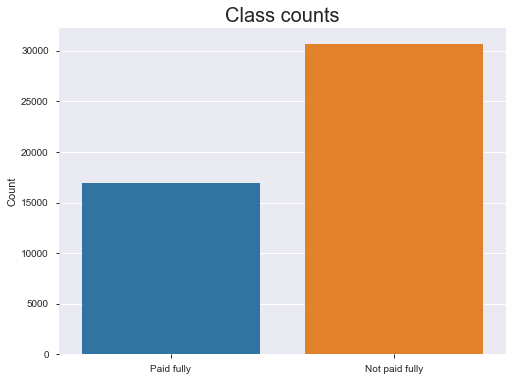

In [13]:
# Get number of positve and negative examples
pos = df[df["loan_repaid"] == 1].shape[0]
neg = df[df["loan_repaid"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(neg/pos) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df["loan_repaid"])
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

In [14]:
#Drop Loan_granted and Date?
df.drop(["loan_granted","date"], axis='columns', inplace=True)

In [15]:
#list of conditions(1=Other, 2=Emergency_funds, 3=Business, 4= Home, 5= Investment)
conditions = [
    (df['loan_purpose'] == "other"),
    (df['loan_purpose'] == "emergency_funds"),
    (df['loan_purpose'] == "business"),
    (df['loan_purpose'] == "home"),
    (df['loan_purpose'] == "investment"),
    ]

In [16]:
# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4, 5]

In [17]:
# create a new column and use np.select to assign values to it using our lists as arguments
df['loan_purpose'] = np.select(conditions, values)

In [18]:
#Fill NA
df['fully_repaid_previous_loans'] = df['fully_repaid_previous_loans'].fillna(0)
df['currently_repaying_other_loans'] = df['currently_repaying_other_loans'].fillna(0)
df['avg_percentage_credit_card_limit_used_last_year'] = df['avg_percentage_credit_card_limit_used_last_year'].fillna(0)

In [19]:
#Change to integers only
#df.astype(int)
df.loan_repaid = df.loan_repaid.apply(int) # round instead of int is you prefer to round
df.fully_repaid_previous_loans = df.fully_repaid_previous_loans.apply(int) 
df.currently_repaying_other_loans = df.currently_repaying_other_loans.apply(int) 

In [20]:
df = df[["loan_repaid", "is_first_loan", "fully_repaid_previous_loans", "currently_repaying_other_loans", "total_credit_card_limit", "avg_percentage_credit_card_limit_used_last_year", "saving_amount" ,"checking_amount", "is_employed" ,"yearly_salary", "age", "dependent_number", "loan_purpose"]]

In [21]:
#df.drop(["is_employed", "avg_percentage_credit_card_limit_used_last_year", "fully_repaid_previous_loans", "currently_repaying_other_loans"], axis='columns', inplace=True)
df.drop(["is_employed", "avg_percentage_credit_card_limit_used_last_year", "fully_repaid_previous_loans"], axis='columns', inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 135565 to 761999
Data columns (total 10 columns):
loan_repaid                       47654 non-null int64
is_first_loan                     47654 non-null int64
currently_repaying_other_loans    47654 non-null int64
total_credit_card_limit           47654 non-null int64
saving_amount                     47654 non-null int64
checking_amount                   47654 non-null int64
yearly_salary                     47654 non-null int64
age                               47654 non-null int64
dependent_number                  47654 non-null int64
loan_purpose                      47654 non-null int64
dtypes: int64(10)
memory usage: 5.2 MB


# Predictive Machine Learning Model

In [19]:
X = df.copy(deep=True)

In [20]:
y = X.pop('loan_repaid')
count = y.count()
print(np.count_nonzero(y < 1))
print(np.count_nonzero(y >= 1))

16948
30706


In [21]:
ss= StandardScaler()
X= ss.fit_transform(X)

Text(0.5, 1, 'Heatmap of correlation')

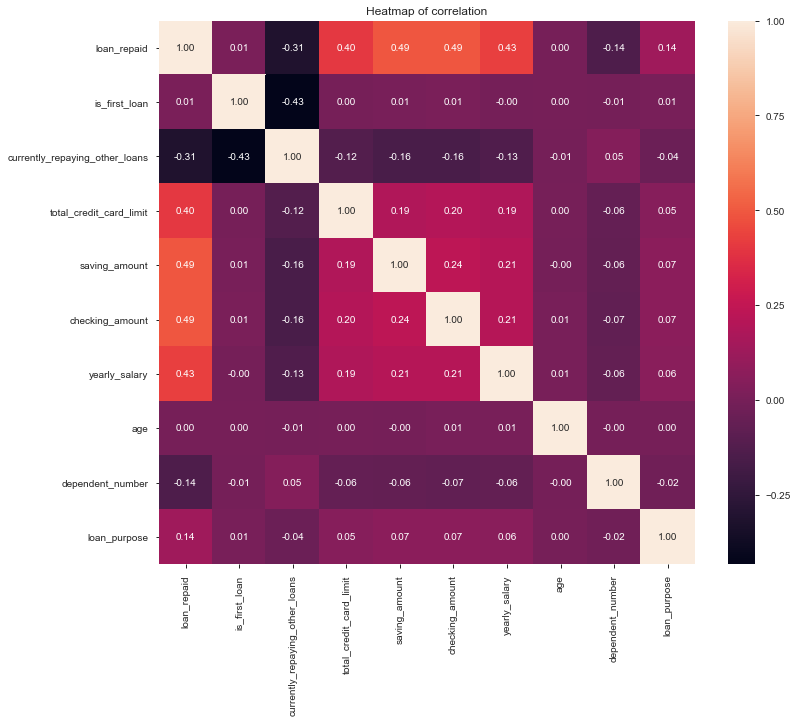

In [22]:
corr = df.corr()
plt.figure(figsize=(12,10))
heat=sns.heatmap(data=corr, annot=True, fmt=".2f")
plt.title('Heatmap of correlation')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size = .20)

In [24]:
count = y_train.count()
print(np.count_nonzero(y_train < 1))
print(np.count_nonzero(y_train >= 1))


13513
24610


In [25]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print('smote target shape %s' % Counter(y_resampled))

smote target shape Counter({0: 24610, 1: 24610})


In [26]:
X_resampled, X_val, y_resampled, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.20, random_state=42)

# CREATE THE MODEL (without tuning)

In [43]:
model = LogisticRegression(random_state=42).fit(X_resampled, y_resampled)

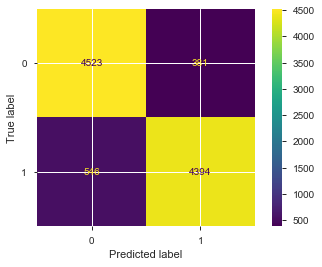

In [44]:
plot_confusion_matrix(model, X_val, y_val, values_format='')

In [45]:
# predict the training data
y_pred= model.predict(X_val)

In [46]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4904
           1       0.92      0.89      0.90      4940

    accuracy                           0.91      9844
   macro avg       0.91      0.91      0.91      9844
weighted avg       0.91      0.91      0.91      9844



In [47]:
print("Accurcay",accuracy_score(y_val, y_pred))
print("Precision", precision_score(y_val, y_pred))
print("Recall",recall_score(y_val, y_pred))
print("F1 score",f1_score(y_val, y_pred))

Accurcay 0.9058309630231614
Precision 0.9202094240837696
Recall 0.8894736842105263
F1 score 0.9045805455481214


# Tuning the hyperparameters

In [84]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [85]:
model = LogisticRegression()

In [87]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

In [88]:
param_dict = dict(C=C, penalty=penalty)

In [89]:
grid = GridSearchCV(model, param_grid = param_dict, cv = 10, verbose=1, n_jobs=-1)
grid.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [90]:
grid.best_params_

{'C': 7.742636826811269, 'penalty': 'l2'}

In [91]:
grid.best_estimator_

LogisticRegression(C=7.742636826811269, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
grid.best_score_

0.9025296012501623

In [93]:
df2 = pd.DataFrame(grid.cv_results_)
df2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.030207,0.013354,0.000000,0.000000,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
1,0.072401,0.026989,0.000982,0.000201,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.89868,0.902235,0.89868,0.900711,0.897664,0.911122,0.906528,0.905766,0.895606,0.908052,0.902504,0.004852,9
2,0.004321,0.000754,0.000000,0.000000,2.78256,l1,"{'C': 2.7825594022071245, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
3,0.035836,0.001746,0.001014,0.000271,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.89868,0.902235,0.89868,0.900965,0.897664,0.911122,0.906528,0.905766,0.895606,0.907798,0.902504,0.004815,10
4,0.004205,0.000850,0.000000,0.000000,7.74264,l1,"{'C': 7.742636826811269, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14


In [95]:
df2[["param_C","param_penalty", "params", "mean_test_score", "std_test_score"]].sort_values(by=['mean_test_score'],ascending=False).head(3)

,param_C,param_penalty,params,mean_test_score,std_test_score
5,7.74264,l2,"{'C': 7.742636826811269, 'penalty': 'l2'}",0.90253,0.00479
7,21.5443,l2,"{'C': 21.544346900318832, 'penalty': 'l2'}",0.90253,0.00479
9,59.9484,l2,"{'C': 59.94842503189409, 'penalty': 'l2'}",0.90253,0.00479


In [48]:
model = LogisticRegression(C=7.742636826811269, penalty= "l2", random_state=42)

In [49]:
# Train SVM
clf= model.fit(X_resampled, y_resampled)
print("Accuracy on training set after tuning: {:.3f}".format(model.score(X_resampled,y_resampled)))

Accuracy on training set after tuning: 0.903


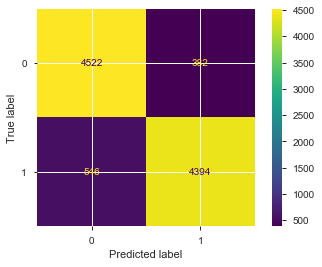

In [50]:
plot_confusion_matrix(model, X_val, y_val, values_format='')

In [51]:
y_pred = model.predict(X_val)

In [52]:
print("Accurcay",accuracy_score(y_val, y_pred))
print("Precision", precision_score(y_val, y_pred))
print("Recall",recall_score(y_val, y_pred))
print("F1 score",f1_score(y_val, y_pred))


Accurcay 0.9057293783015035
Precision 0.9200167504187605
Recall 0.8894736842105263
F1 score 0.9044874433923425


# Testdata with tuning 

In [38]:
model = LogisticRegression(C=7.742636826811269, penalty= "l2").fit(X_resampled, y_resampled)


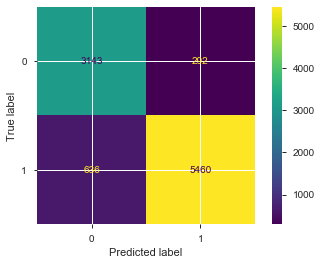

In [39]:
plot_confusion_matrix(model, X_test, y_test, values_format='')

In [40]:
y_pred= model.predict(X_test)

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3435
           1       0.95      0.90      0.92      6096

    accuracy                           0.90      9531
   macro avg       0.89      0.91      0.90      9531
weighted avg       0.91      0.90      0.90      9531



In [42]:
print("Accurcay",accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("F1 score",f1_score(y_test, y_pred))

Accurcay 0.9026335116986675
Precision 0.9492350486787204
Recall 0.8956692913385826
F1 score 0.9216745442268737
